In [1]:
%config Completer.use_jedi=False

In [2]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator

from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)


### Import Data and Normalizing
***ImageDataGenerator*** allows me to divide my data on the fly without consuming memory for doing so.

then resize the images to be (256x256)

In [3]:
# ImageDataGenerator:
#     Generate batches of tensor image data with real-time data augmentation.

train_datagen = ImageDataGenerator(rescale=1. / 255)  

In [4]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
type(train_datagen)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

In [6]:
length_train = 3330          # number of images in train dataset
path_train = '.\datasets\Train'
    
train = train_datagen.flow_from_directory(path_train, target_size=(256, 256), batch_size=length_train, class_mode=None)

Found 3330 images belonging to 6 classes.


In [7]:
# train.batch_size

In [8]:
length_test = 99           # number of images in test dataset
path_test = '.\datasets\Test'

test = test_datagen.flow_from_directory(path_test, target_size=(256, 256), batch_size=length_test, class_mode=None)

Found 99 images belonging to 6 classes.


In [9]:
type(train[0]), train[0].shape

(numpy.ndarray, (3330, 256, 256, 3))

In [10]:
type(test[0][1]), test[0][1].shape

(numpy.ndarray, (256, 256, 3))

In [11]:
# train.batch_size, type(train), dir(train)

(-0.5, 255.5, 255.5, -0.5)

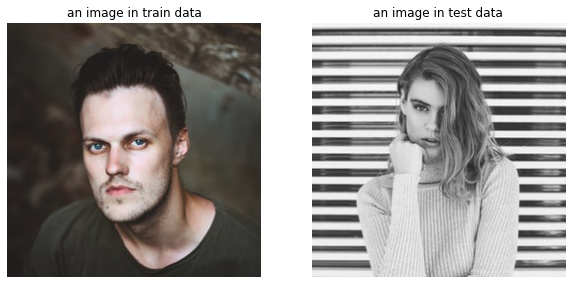

In [12]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(train[0][10])
plt.title('an image in train data')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(test[0][5])
plt.title('an image in test data')

plt.axis('off')

### Preproccessing

#### conversion from RGB to Lab:

In [13]:
def get_l_ab(images_batch):
    """
    This function converts images from RGB to LAB and returns 2 vectors, one L channel and the other AB channels.
    L channel is grayscale image and AB channels are (like) informations about colors of an image.
    
    Input:
    images_batch: A dataset of images(in RGB space, so in shape ( , , 3))
    
    Return:
    X: Vectors of grayscale images of given images.
    Y: Vector of AB channels of given images.
    """
    X =[]
    Y =[]
    for img in images_batch:
        try:
            lab = rgb2lab(img)
            X.append(lab[:,:,0])         # X = the L channel: grayscale image
            Y.append(lab[:,:,1:] / 128)  # Y = the AB channels: color infos
                                         # I need to divide Y by 128 because the range of values of 
                                         # ab channel is between (-127, 128)
        except:
            print('error')

    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape+(1,))         # add this line X=X.reshape(X.shape+(1,)) 
                                        # because I want dimensions to be the same for X and Y.
    return X, Y

In [14]:
X_train, Y_train = get_l_ab(train[0])

In [15]:
X_train.shape

(3330, 256, 256, 1)

(-0.5, 255.5, 255.5, -0.5)

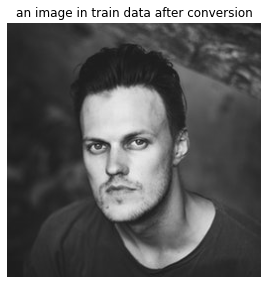

In [16]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
a = np.zeros((256,256,3))
a[:,:,0] = X_train[10][:,:,0]
a_n = lab2rgb(a)
plt.imshow(a_n, cmap='gray')
plt.title('an image in train data after conversion')
plt.axis('off')


### Train the Model
   - The ***encoder*** part consists of some convolutional layers with activation function ReLU and, Strides=2 for decreasing the width and height of the latent space vector.<br>
   
   
   - The ***decoder*** part consists of convolutional layers with upsampling layers to restore the dimensions of the original input image (256x256) and reconstruct the image with 2 filters at the last layer which represents the ab channels. The last layer I used ***tanh*** activation function instead of ReLU, because I normalized the ab values to be between (-1,1) and tanh used for squashing the values between (-1,1).<br>

In [17]:
#Encoder
encoder_input = Input(shape=(256, 256, 1))
encoder_output = Conv2D( 64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)

In [ ]:
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

model.fit(X_train, Y_train, validation_split=0.2, batch_size=256, epochs=100, verbose=1) 

Epoch 1/100


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       118016

In [ ]:
# model.history.params

{'epochs': 1, 'steps': 1, 'verbose': 0}

as I do in the preprocessing for training, I do the same before testing. it doesn’t matter if the testing image is in grayscale or colored because in both ways I extract the L channel and predict with the grayscale image.

In [ ]:
X_test, Y_test = get_l_ab(test[0])

### Prediction
- The "output" is predictions of the colors information (AB channels) of inputs images(hier "X_test")
- After predicting, the values will be in range (-1,1). that’s is because I used ***tanh*** function at the last layer so, I have to multiply the values by 128 to restore the values of ab channels.

In [ ]:
output = model.predict(X_test)   
                                  
output = output * 128           

In [ ]:
output.shape

(10, 256, 256, 2)

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(10,30), sharex=True, sharey=True)

row = 0
n = 10

# Output colorizations
for i in range(10):
    t = np.zeros((256, 256, 3))
    t[:,:,0] = X_test[i][:,:,0]
    t_n = lab2rgb(t)
    ax[row,0].imshow(t_n, interpolation='nearest', cmap='gray')
    plt.axis('off')
    
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = X_test[i][:,:,0]    # the first channel (L) of input images is used for first channel of result images
    cur[:,:,1:] = output[i]          #  the outputs (predict of channel AB) are used for second and thired channels of 
                                       # result images.
    resImage = lab2rgb(cur)
    ax[row,1].imshow(resImage, interpolation='nearest', cmap='gray')
    plt.axis('off')

    org = np.zeros((256, 256, 3))
    org[:,:,0] = X_test[i][:,:,0]
    org[:,:,1:] = Y_test[i]*128
    
    org_img = lab2rgb(org)
    ax[row, 2].imshow(org_img, interpolation='nearest', cmap='gray')
    plt.axis('off')

    row +=1
    imsave(".\\projekt\\result\\img"+str(i)+".jpeg", resImage);
plt.tight_layout()   
    

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
 X_test[i][:,:,0].shape

(256, 256)

In [ ]:
Xtrain_test = X_train[10:20]
Ytrain_test = Y_train[10:20]

In [ ]:
Xtrain_test.shape, Ytrain_test.shape

((10, 256, 256, 1), (10, 256, 256, 2))

In [ ]:
predict = model.predict(Xtrain_test)
predict *= 128

In [ ]:
fig, ax = plt.subplots(10, 3, figsize=(10,30), sharex=True, sharey=True)

row = 0

# Output colorizations
for i in range(len(predict)):
    
    t = np.zeros((256, 256, 3))
    t[:,:,0] = Xtrain_test[i][:,:,0]
    t_n = lab2rgb(t)
    ax[row,0].imshow(t_n, interpolation='nearest', cmap='gray')
    plt.axis('off')
    
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = Xtrain_test[i][:,:,0]    # the first channel (L) of input images is used for first channel of result images
    cur[:,:,1:] = predict[i]          #  the outputs (predict of channel AB) are used for second and thired channels of 
                                       # result images.
    resImage = lab2rgb(cur)
    ax[row,1].imshow(resImage, interpolation='nearest', cmap='gray')
    plt.axis('off')

    org = np.zeros((256, 256, 3))
    org[:,:,0] = Xtrain_test[i][:,:,0]
    org[:,:,1:] = Ytrain_test[i]*128
    
    org_img = lab2rgb(org)
    ax[row, 2].imshow(org_img, interpolation='nearest', cmap='gray')
    plt.axis('off')

    row +=1
#     imsave(".\\projekt\\result\\"+str(i)+".jpeg", resImage);
plt.tight_layout()   
    

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# model.save('colorizer_flowers5000.h5')